In [140]:
import pandas as pd
import numpy as np
import igraph as ig
from tqdm import tqdm
import networkx as nx
import matplotlib.pyplot as plt

In [141]:
#The graph is made of 203,769 nodes and 234,355 edges. Two percent (4,545) of the nodes are 
# labelled class1 (illicit).
#Twenty-one percent (42,019) are labelled class2 (licit). 
#The remaining transactions are not labelled with regard to licit versus illicit.
classes_path = "../elliptic_bitcoin_dataset/elliptic_txs_classes.csv"
edges_path = "../elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv"
features_path = "../elliptic_bitcoin_dataset/elliptic_txs_features.csv"

classes = pd.read_csv(classes_path)
edges = pd.read_csv(edges_path)
feat_cols = ['txId', 'time_step'] + [f'trans_feat_{i}' for i in range(93)] + [f'agg_feat_{i}' for i in range(72)]
feats = pd.read_csv(features_path, header=None, names=feat_cols)
classes.columns = ['txId', 'label']
df = classes.set_index('txId').join(feats.set_index('txId'))

In [142]:
label_colors = {'1':'red', '2':'green', 'unknown':'gray'}

tx_graph = ig.Graph(directed=True)

edges_dict = {tx_id: i for i, tx_id in enumerate(classes['txId'])}

tx_graph.add_vertices(len(classes))
tx_graph.vs['id'] = list(classes['txId'])
tx_graph.vs['type'] = list(classes['label'])
tx_graph.vs['time_step'] = list(feats['time_step'])
tx_graph.vs['color'] = [label_colors[label] for label in classes['label']]

edges_list = [(edges_dict[edges['txId1'][i]], edges_dict[edges['txId2'][i]]) for i in tqdm(range(len(edges)))]
tx_graph.add_edges(edges_list)

100%|██████████| 234355/234355 [00:00<00:00, 269998.90it/s]


In [143]:
betweenness = tx_graph.betweenness(directed=True)
df.insert(1, 'betweenness', betweenness, True)

In [144]:
centralities = tx_graph.closeness()
df.insert(1, 'closeness', centralities, True)

In [145]:
in_degree = tx_graph.degree(mode="in")
df.insert(1, 'in-degree', in_degree)

In [146]:
out_degree = tx_graph.degree(mode='out')
df.insert(1, 'out-degree', out_degree)

In [147]:
pagerank_scores = tx_graph.pagerank(directed=True)
df.insert(1, 'pagerank', pagerank_scores, True)

In [148]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [149]:
#IMP
#To consider also the weights of incoming and outgoing weights we might want to add a feature
#that represent the difference between them

In [150]:
#Transform the dataframe in a suitable input for KMeans. We drop the columns containing
#the correct labels
x = df.drop(columns=['label']).to_numpy()

In [151]:
#k-means++ : selects initial cluster centroids using sampling based on an empirical probability distribution of the points’ contribution to the overall inertia
kmeans = KMeans(n_clusters=2, random_state=0, n_init="auto").fit(x)
unique, counts = np.unique(kmeans.labels_, return_counts=True)
counts
#The following results are obtained without apllying PCA

array([201648,   2121])

In [152]:
#First set the dimensions of resulting features space
number_of_dimensions = 2
pca = PCA(n_components=number_of_dimensions)
# pca=PCA()
scaler = StandardScaler()
#Standardize features by removing the mean and scaling to unit variance.
#Note: scaler is sensible to outliers
x_scaled = scaler.fit_transform(x)
x_pca = pca.fit_transform(x_scaled)
print(pca.explained_variance_ratio_*100)

[10.12003396  6.42379945]


In [153]:
print(pca.singular_values_)

[1877.83788801 1496.10853064]


In [154]:
#fit and predict the cluster for each sample and then adjust them for coherence with original 
#class labels
clusters = KMeans(n_clusters=2, random_state=0, n_init="auto").fit_predict(x_pca)
clusters += 1
unique, counts = np.unique(clusters, return_counts=True)
print('Labels:', unique)
print('Size of clusters:', counts)

Labels: [1 2]
Size of clusters: [193946   9823]


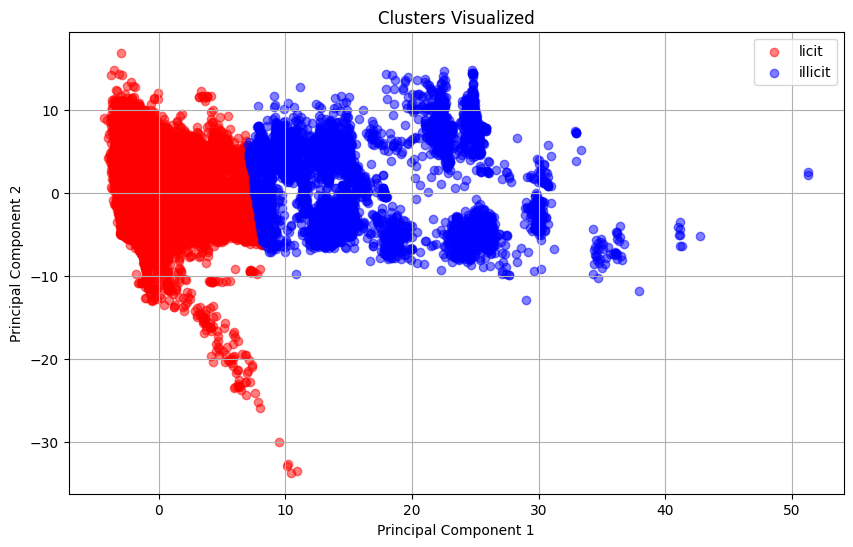

In [155]:
#plotting the results:
plt.figure(figsize=(10, 6))

plt.scatter(x_pca[clusters == 1, 0], x_pca[clusters == 1, 1], c='red', label='licit', alpha=0.5)
plt.scatter(x_pca[clusters == 2, 0], x_pca[clusters == 2, 1], c='blue', label='illicit', alpha=0.5)
# Add labels and title
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Clusters Visualized')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()